In [1]:
# Basic imports
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2024-03-30 18:06:23.834822: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 18:06:23.834870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 18:06:23.834909: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 18:06:23.843682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [3]:
df = pd.concat([train,test])

In [4]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [5]:
df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  

In [7]:
print(df.duplicated().sum(), "fully duplicate rows to remove")

0 fully duplicate rows to remove


In [8]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [9]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state']  
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [10]:
X_train

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,state_CLO,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
102468,102469,0.210396,10,10,1000,4664,90.305896,62,252,3.422118e+04,...,False,False,False,True,False,False,False,False,False,False
64802,64803,5.619431,138,38,162294,2612,31.141943,62,252,2.293727e+05,...,False,False,False,True,False,False,False,False,False,False
33634,33635,0.000977,2,2,132,164,3070.624396,31,29,5.404299e+05,...,False,True,False,False,False,False,False,False,False,False
27874,27875,0.037950,60,62,3614,50036,3188.405658,31,29,7.491962e+05,...,False,False,False,True,False,False,False,False,False,False
99000,99001,0.767809,22,30,1040,18514,66.422771,62,252,1.034632e+04,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37547,37548,0.031852,60,62,3598,48710,3798.819605,31,29,8.888610e+05,...,False,False,False,True,False,False,False,False,False,False
21362,21363,0.191118,22,26,2054,2582,245.921365,31,29,8.208541e+04,...,False,False,False,True,False,False,False,False,False,False
49600,49601,1.394700,12,10,2026,788,15.057001,254,252,1.065749e+04,...,False,False,False,True,False,False,False,False,False,False
64535,64536,0.754238,22,36,1040,26328,75.572961,62,252,1.053248e+04,...,False,False,False,True,False,False,False,False,False,False


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

#  grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_rf.fit(X_train_scaled, y_train_encoded)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best score: {grid_search_rf.best_score_}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=  22.9s[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  23.2s

[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  23.9s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  24.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=  23.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  24.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  24.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total ti

/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  48.6s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  27.1s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.7min
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  28.1s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  27.5s
[CV] END criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  28.7s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.5min
[CV] END criterion=gini, max_depth=30, min_sam

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.21      0.33       538
           1       0.39      0.07      0.12       471
           2       0.41      0.18      0.25      3293
           3       0.64      0.90      0.74      8853
           4       0.91      0.88      0.90      4742
           5       1.00      0.98      0.99     11849
           6       1.00      1.00      1.00     18675
           7       0.93      0.76      0.83      2770
           8       0.71      0.57      0.64       318
           9       0.80      0.15      0.26        26

    accuracy                           0.88     51535
   macro avg       0.75      0.57      0.61     51535
weighted avg       0.88      0.88      0.87     51535

Confusion Matrix:
[[  113    18    45   353     8     0     0     1     0     0]
 [   12    35    44   359    14     0     0     5     2     0]
 [    4     7   598  2574    59     4     1    22    24     0]
 [   13    

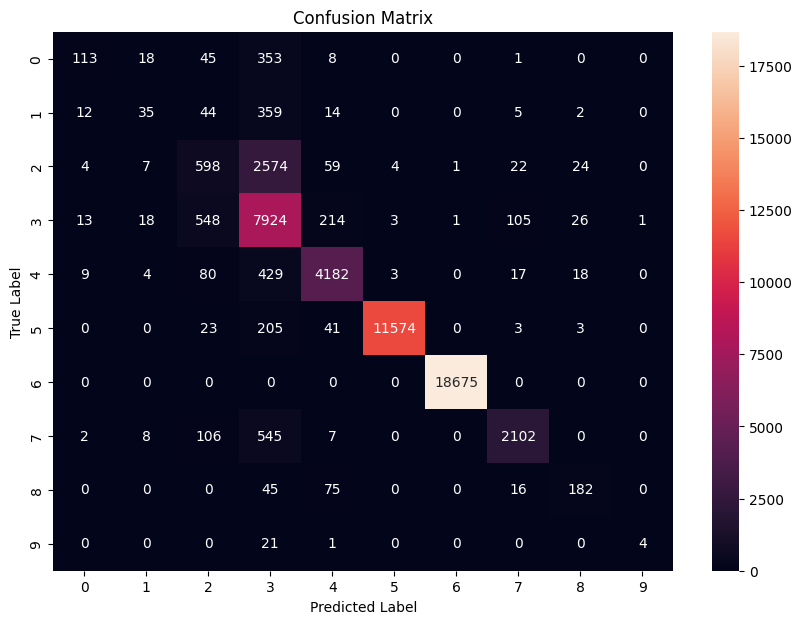

Overall Accuracy: 0.8807
Overall Precision: 0.8773
Overall Recall: 0.8807
Overall F1 Score: 0.8692


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest Classifier with the best parameters
rf_optimized = RandomForestClassifier(
    criterion='gini', 
    max_depth=20, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=200,
    random_state=42
)

rf_optimized.fit(X_train_scaled, y_train_encoded)

y_pred_rf_optimized = rf_optimized.predict(X_test_scaled)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf_optimized))

# Print and plot the confusion matrix
conf_matrix_rf_optimized = confusion_matrix(y_test_encoded, y_pred_rf_optimized)
print("Confusion Matrix:")
print(conf_matrix_rf_optimized)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_rf_optimized, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

accuracy_rf_optimized = accuracy_score(y_test_encoded, y_pred_rf_optimized)
precision_rf_optimized, recall_rf_optimized, f1_rf_optimized, _ = precision_recall_fscore_support(y_test_encoded, y_pred_rf_optimized, average='weighted')

print(f"Overall Accuracy: {accuracy_rf_optimized:.4f}")
print(f"Overall Precision: {precision_rf_optimized:.4f}")
print(f"Overall Recall: {recall_rf_optimized:.4f}")
print(f"Overall F1 Score: {f1_rf_optimized:.4f}")


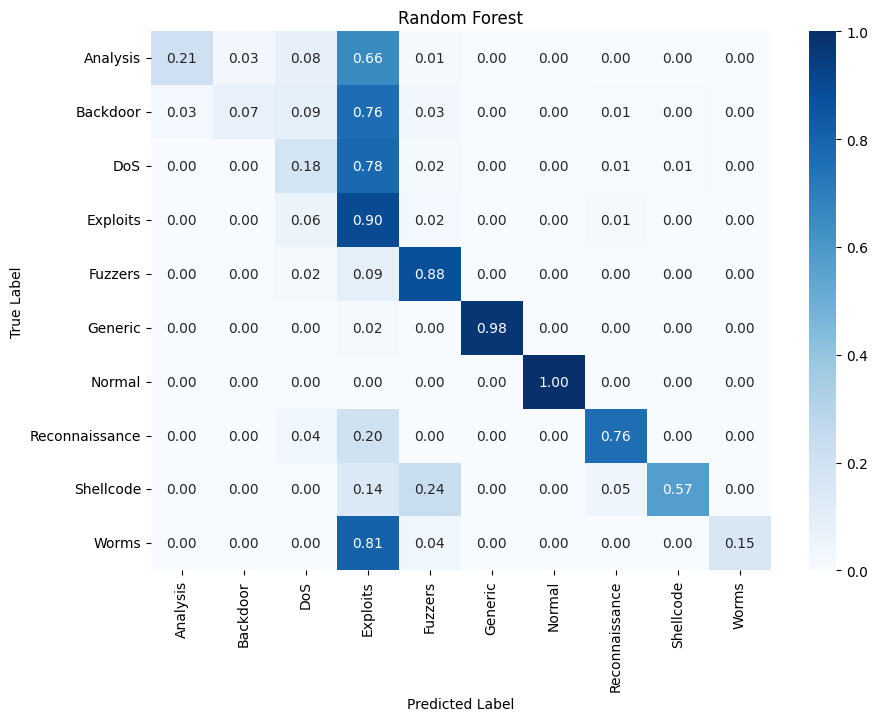

In [12]:
# Normalize the confusion matrix by rows
row_sums = conf_matrix_rf_optimized.sum(axis=1)
conf_matrix_normalized = conf_matrix_rf_optimized / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [13]:
from sklearn.metrics import precision_recall_fscore_support





precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test_encoded, y_pred_rf_optimized, average='weighted')
print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1-Score: {f1_score_weighted:.4f}")

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_test_encoded, y_pred_rf_optimized, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f"Overall Accuracy: {accuracy_rf_optimized:.4f}")


Weighted Average Precision: 0.8773
Weighted Average Recall: 0.8807
Weighted Average F1-Score: 0.8692
Micro Average Precision: 0.7525
Micro Average Recall: 0.5705
Micro Average F1-Score: 0.6058
Overall Accuracy: 0.8807


In [14]:
# Basic imports
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
train = pd.read_csv(r"../unsw_dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv(r"../unsw_dataset/UNSW_NB15_testing-set.csv")


In [16]:
df = pd.concat([train,test])

In [17]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['attack_cat'] = le.fit_transform(df['attack_cat'])

X = df_encoded.drop('attack_cat', axis=1)
y = df_encoded['attack_cat']

In [18]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# One-hot encode categorical features
categorical_columns = ['proto', 'service', 'state'] 
X = pd.get_dummies(df.drop('attack_cat', axis=1), columns=categorical_columns)
y = df['attack_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd

In [20]:
# Define the sampling strategies
sampling_strategy_over = {
    "Generic": 50000,
    "Exploits": 45000,
    "Fuzzers": 25000,
    "DoS": 15000,
    "Reconnaissance": 12000,
    "Analysis": 3000,
    "Backdoor": 2000,
    "Shellcode": 2000,
    "Worms": 500
}

sampling_strategy_under = {
    "Normal": 70000
}

over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

In [21]:
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())

attack_cat
Normal            70000
Generic           50000
Exploits          45000
Fuzzers           25000
DoS               15000
Reconnaissance    12000
Analysis           3000
Backdoor           2000
Shellcode          2000
Worms               500
Name: count, dtype: int64


In [22]:


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train_scaled, y_train_encoded)

print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best score: {grid_search_rf.best_score_}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  24.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  23.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  23.6s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  23.6s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  24.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=  23.9s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  24.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total tim

/x1/rsingh8/anaconda3/envs/tf_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  52.2s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  53.1s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  24.2s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  23.2s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.6min
[CV] END criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  23.5s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  50.2s[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  49.8s

[CV] END criterion=gini, max_depth=20, min_samples_leaf=1, min_s

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.22      0.31       538
           1       0.22      0.09      0.13       471
           2       0.40      0.24      0.30      3293
           3       0.66      0.86      0.75      8853
           4       0.91      0.89      0.90      4742
           5       1.00      0.98      0.99     11849
           6       1.00      1.00      1.00     18675
           7       0.90      0.77      0.83      2770
           8       0.69      0.66      0.67       318
           9       0.44      0.31      0.36        26

    accuracy                           0.88     51535
   macro avg       0.68      0.60      0.62     51535
weighted avg       0.88      0.88      0.87     51535

Confusion Matrix:
[[  119    54    75   272    16     0     0     2     0     0]
 [   48    43    69   265    19     1     0    24     2     0]
 [   16    24   790  2325    56    11     1    43    26     1]
 [   18    

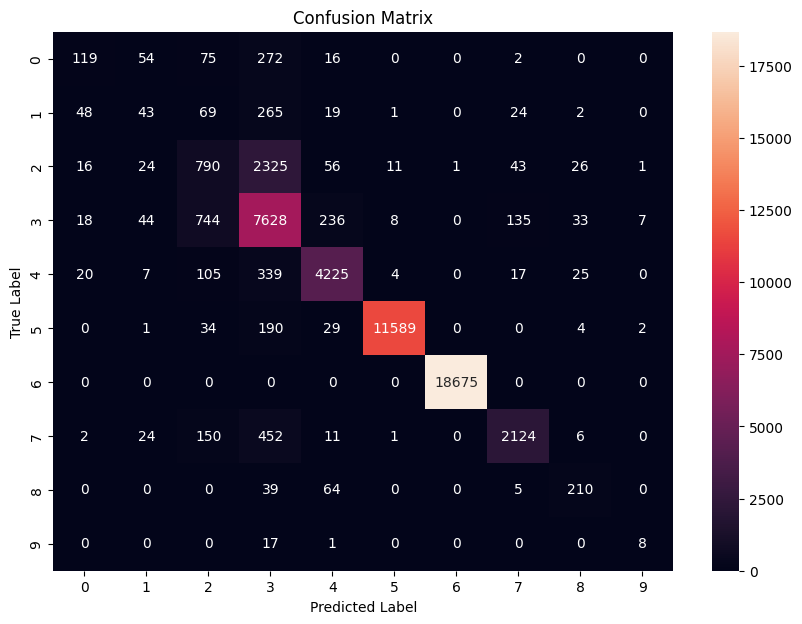

Overall Accuracy: 0.8812
Overall Precision: 0.8752
Overall Recall: 0.8812
Overall F1 Score: 0.8734


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

rf_optimized = RandomForestClassifier(
    criterion='gini', 
    max_depth=30, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=200,
    random_state=42
)

rf_optimized.fit(X_train_scaled, y_train_encoded)

y_pred_rf_optimized = rf_optimized.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf_optimized))

# Print and plot the confusion matrix
conf_matrix_rf_optimized = confusion_matrix(y_test_encoded, y_pred_rf_optimized)
print("Confusion Matrix:")
print(conf_matrix_rf_optimized)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_rf_optimized, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate and print overall accuracy, precision, recall, and F1 score
accuracy_rf_optimized = accuracy_score(y_test_encoded, y_pred_rf_optimized)
precision_rf_optimized, recall_rf_optimized, f1_rf_optimized, _ = precision_recall_fscore_support(y_test_encoded, y_pred_rf_optimized, average='weighted')

print(f"Overall Accuracy: {accuracy_rf_optimized:.4f}")
print(f"Overall Precision: {precision_rf_optimized:.4f}")
print(f"Overall Recall: {recall_rf_optimized:.4f}")
print(f"Overall F1 Score: {f1_rf_optimized:.4f}")


Confusion Matrix:
[[  119    54    75   272    16     0     0     2     0     0]
 [   48    43    69   265    19     1     0    24     2     0]
 [   16    24   790  2325    56    11     1    43    26     1]
 [   18    44   744  7628   236     8     0   135    33     7]
 [   20     7   105   339  4225     4     0    17    25     0]
 [    0     1    34   190    29 11589     0     0     4     2]
 [    0     0     0     0     0     0 18675     0     0     0]
 [    2    24   150   452    11     1     0  2124     6     0]
 [    0     0     0    39    64     0     0     5   210     0]
 [    0     0     0    17     1     0     0     0     0     8]]


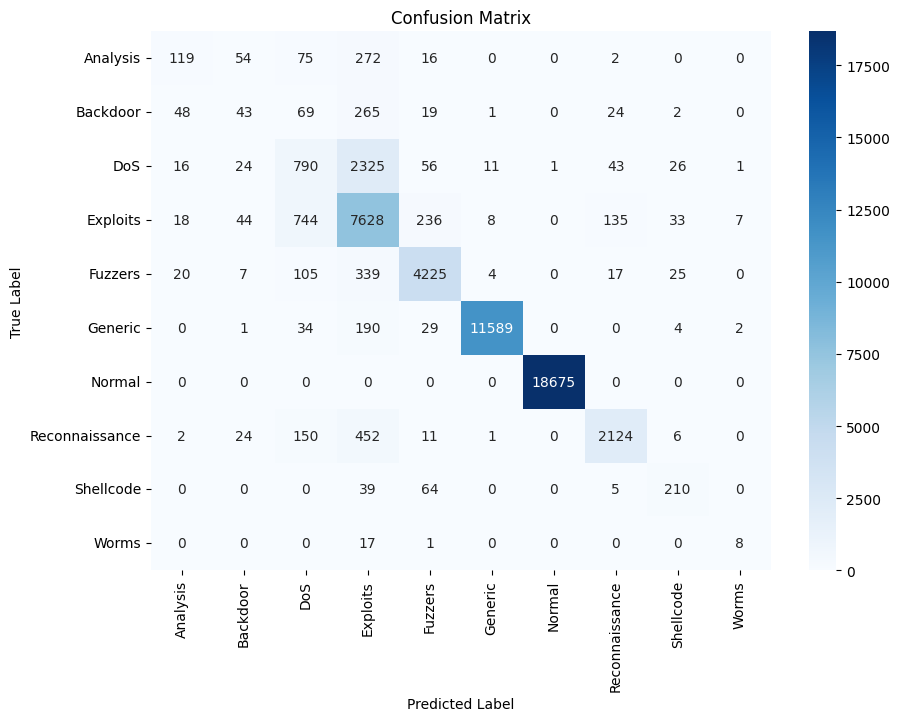

In [24]:
class_names = label_encoder.classes_
conf_matrix_rf_optimized = confusion_matrix(y_test_encoded, y_pred_rf_optimized)
print("Confusion Matrix:")
print(conf_matrix_rf_optimized)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_rf_optimized, annot=True, fmt="d",cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


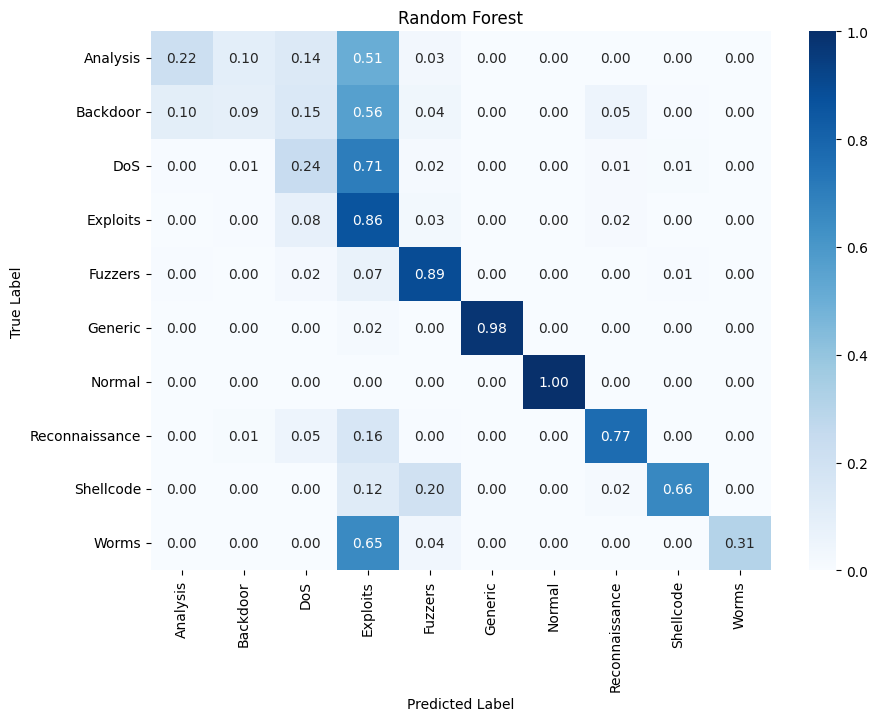

In [25]:
# Normalize the confusion matrix by rows
row_sums = conf_matrix_rf_optimized.sum(axis=1)
conf_matrix_normalized = conf_matrix_rf_optimized / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',xticklabels=le.classes_, yticklabels=le.classes_)  # Use fmt=".2f" to format the numbers
plt.title("Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [26]:
from sklearn.metrics import precision_recall_fscore_support





precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test_encoded, y_pred_rf_optimized, average='weighted')
print(f"Weighted Average Precision: {precision_weighted:.4f}")
print(f"Weighted Average Recall: {recall_weighted:.4f}")
print(f"Weighted Average F1-Score: {f1_score_weighted:.4f}")

precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_test_encoded, y_pred_rf_optimized, average='macro')
print(f"Micro Average Precision: {precision_micro:.4f}")
print(f"Micro Average Recall: {recall_micro:.4f}")
print(f"Micro Average F1-Score: {f1_score_micro:.4f}")

print(f"Overall Accuracy: {accuracy_rf_optimized:.4f}")


Weighted Average Precision: 0.8752
Weighted Average Recall: 0.8812
Weighted Average F1-Score: 0.8734
Micro Average Precision: 0.6755
Micro Average Recall: 0.6018
Micro Average F1-Score: 0.6244
Overall Accuracy: 0.8812


In [ ]:
Overall Accuracy: 0.8812
Overall Precision: 0.8752
Overall Recall: 0.8812
Overall F1 Score: 0.8734